# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Behzad | Nourollahkhani | Behzad Nourollahkhani (November 4, 2024) | 6 | 25% |
| Member 2: | Bernard | Gyasi | Bernard Gyasi (November 4, 2024) | 6 | 25% |
| Member 3: | Faezeh  | Yousefzadeh | Faezeh Yousefzadeh (November 4, 2024) | 6 | 25% |
| Member 4: | Rashid | Bawah | Rashid Bawah (November 4, 2024) | 6 | 25% |

# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

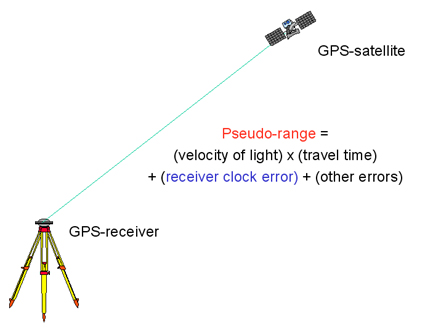

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [2]:
df_pseudorange = pd.read_excel('pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [3]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [4]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [5]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [6]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    """
    Calculate the sum of squared residuals between measured and predicted pseudoranges.
    
    Parameters:
    r_pos (numpy array): Receiver's coordinates (x, y, z) in ECEF.
    cdT (float): Receiver's clock offset (in meters).
    s_pos (numpy array): Satellites' coordinates, shape (n, 3).
    pseudorange (numpy array): Observed pseudoranges, shape (n,).
    
    Returns:
    float: Sum of squared residuals (cost).
    """
    predicted_distance = euclidean_norm(r_pos, s_pos) + cdT
    
    residuals = pseudorange - predicted_distance
    
    L = np.sum(residuals ** 2)
    
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [7]:
# # Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
# def gradient(r_pos, cdT, s_pos, pseudorange):
#     """
#     Calculate the gradient of the cost function with respect to the receiver's coordinates and clock offset.
    
#     Parameters:
#     r_pos (numpy array): Receiver's coordinates (x, y, z) in ECEF.
#     cdT (float): Receiver's clock offset (in meters).
#     s_pos (numpy array): Satellites' coordinates, shape (n, 3).
#     pseudorange (numpy array): Observed pseudoranges, shape (n,).
    
#     Returns:
#     numpy array: Gradient vector with respect to (x_r, y_r, z_r, cdT).
#     """
#     # geometric distance between receiver and each satellite
#     geom_dist = euclidean_norm(r_pos, s_pos)
    
#     # predicted pseudorange (geometric distance + clock offset)
#     predicted_distance = geom_dist + cdT
    
#     # residuals
#     residuals = pseudorange - predicted_distance
    
#     # partial derivatives with respect to x_r, y_r, and z_r
#     # for each satellite and sum them up
#     delta_pos = s_pos - r_pos  # Differences between satellite and receiver positions
#     geom_dist = geom_dist.reshape(-1, 1)  # Reshape for broadcasting
    
#     # Avoid division by zero for any zero distances
#     safe_dist = np.where(geom_dist == 0, 1, geom_dist)
    
#     # Partial derivatives with respect to x_r, y_r, and z_r
#     dL_dxyz = -np.sum((residuals / safe_dist)[:, None] * delta_pos, axis=0)
    
#     # Partial derivative with respect to cdT
#     dL_dcdT = -np.sum(residuals)
    
#     # Combining the partial derivatives into a single gradient vector
#     grad = np.append(dL_dxyz, dL_dcdT)
    
#     return grad


# Define the gradient computation function for the cost function with respect to receiver coordinates and clock offset
def gradient(r_pos, cdT, s_pos, pseudorange):
    """
    Calculate the gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT).
    
    Parameters:
    r_pos (numpy array): Receiver's coordinates (x, y, z) in ECEF.
    cdT (float): Receiver's clock offset (in meters).
    s_pos (numpy array): Satellites' coordinates, shape (n, 3).
    pseudorange (numpy array): Observed pseudoranges, shape (n,).
    
    Returns:
    numpy array: Gradient vector of shape (4,).
    """
    # Calculate the predicted geometric distance between receiver and each satellite
    predicted_distance = euclidean_norm(r_pos, s_pos)

    # Calculate residuals (difference between observed pseudorange and predicted values adjusted by clock offset)
    residuals = pseudorange - (predicted_distance + cdT)

    # Calculate partial derivatives with respect to each component of the receiver's position (x_r, y_r, z_r)
    delta_r = s_pos - r_pos  # Difference between satellite and receiver positions
    distance = predicted_distance[:, np.newaxis]  # Reshape for element-wise division

    # Avoid division by zero by replacing zero distances with a small value
    # distance[distance == 0] = 1e-10
    distance = distance + 1e-10

    # Compute partial derivatives w.r.t x_r, y_r, z_r
    partials = (delta_r / distance) * residuals[:, np.newaxis]  # Element-wise scale by residuals
    grad_r = -2 * np.sum(partials, axis=0)  # Summing up for all satellites and scaling by -2

    # Gradient with respect to cdT (clock offset)
    grad_cdT = -2 * np.sum(residuals)

    # Combine gradients into a single array
    grad = np.append(grad_r, grad_cdT)
    
    return grad

# Display the function to confirm adherence to the given structure
def gradient(r_pos, cdT, s_pos, pseudorange):
    """
    Calculate the gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
    using a hybrid approach that combines separate component calculations with division-by-zero handling.
    
    Parameters:
    r_pos (numpy array): Receiver's coordinates (x, y, z) in ECEF.
    cdT (float): Receiver's clock offset (in meters).
    s_pos (numpy array): Satellites' coordinates, shape (n, 3).
    pseudorange (numpy array): Observed pseudoranges, shape (n,).
    
    Returns:
    numpy array: Gradient vector of shape (4,).
    """
    # Calculate the predicted geometric distance between receiver and each satellite
    predicted_range = euclidean_norm(r_pos, s_pos)

    # Avoid division by zero by replacing zero distances with a small value
    predicted_range[predicted_range == 0] = 1e-10

    # Adjusted predicted range with clock offset
    adjusted_range = predicted_range + cdT

    # Residuals between observed and adjusted predicted pseudoranges
    residuals = pseudorange - adjusted_range

    # Calculate partial derivatives with respect to x_r, y_r, z_r individually
    dL_dx = np.sum(-2 * residuals * (r_pos[0] - s_pos[:, 0]) / predicted_range)
    dL_dy = np.sum(-2 * residuals * (r_pos[1] - s_pos[:, 1]) / predicted_range)
    dL_dz = np.sum(-2 * residuals * (r_pos[2] - s_pos[:, 2]) / predicted_range)

    # Partial derivative with respect to clock offset (cdT)
    dL_dcdT = np.sum(-2 * residuals)

    # Gradient vector
    grad = np.array([dL_dx, dL_dy, dL_dz, dL_dcdT])

    return grad


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [8]:
# Complete the gradient_descent function as per the given structure without altering comments or layout
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    # initialize the estimates as zeros
    X = np.array([0, 0, 0, 0], dtype=float)

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count = iteration
            break

        # update the parameters for the next iteration
        X = X_new

        # collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)
        # print(f"Iteration {iteration+1}: {arr_err[iteration]}")

    return X

# Display the function to confirm structure adherence
gradient_descent


<function __main__.gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-06)>

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [9]:
print(f"Before: {len(arr_err)}")

optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
# Extract results
final_position_error = optimized_params[:3] - GroundTruth  # Error between estimated and ground truth position
final_cost_value = arr_cost[-1] if arr_cost else None  # Final cost value
final_gradient_values = arr_grad[-1] if arr_grad else None  # Final gradient values

# Print the required outputs
print("Optimized Parameters:", optimized_params)
print("Final Position Error of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_value)
print("Final Gradient Values:", final_gradient_values)

print(f"After: {len(arr_err)}")

Before: 0
Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Error of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]
After: 2871


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

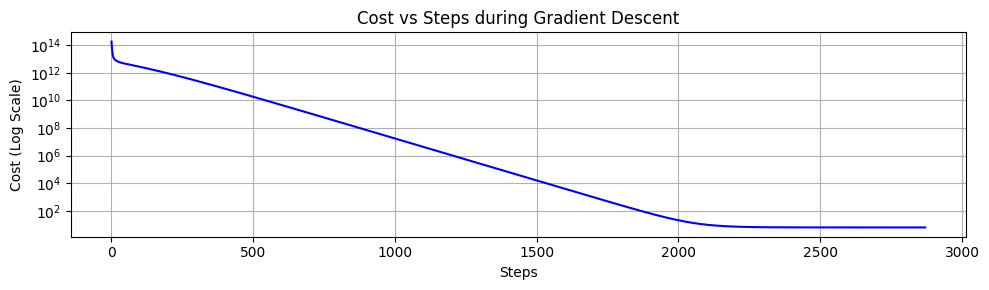


        The convergence pattern of the cost function in gradient descent typically follows three main stages: 
        an initial rapid descent, a gradual slowdown, and final convergence. 
        Initially, the cost decreases sharply due to large gradient values that drive significant updates toward 
        the optimal region. As the estimates approach this region, the gradient values become smaller, slowing down 
        the rate of cost reduction as the algorithm fine-tunes the parameters. Finally, the cost curve flattens, indicating 
        that the algorithm has reached a near-constant value and converged to an optimal solution. This pattern, visualized 
        with a logarithmic scale, highlights the diminishing returns on cost reduction as the algorithm stabilizes near 
        the minimum.
    


In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.semilogy(arr_cost, color="blue")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (Log Scale)")
ax.set_title("Cost vs Steps during Gradient Descent")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print(
    """
        The convergence pattern of the cost function in gradient descent typically follows three main stages: 
        an initial rapid descent, a gradual slowdown, and final convergence. 
        Initially, the cost decreases sharply due to large gradient values that drive significant updates toward 
        the optimal region. As the estimates approach this region, the gradient values become smaller, slowing down 
        the rate of cost reduction as the algorithm fine-tunes the parameters. Finally, the cost curve flattens, indicating 
        that the algorithm has reached a near-constant value and converged to an optimal solution. This pattern, visualized 
        with a logarithmic scale, highlights the diminishing returns on cost reduction as the algorithm stabilizes near 
        the minimum.
    """
)

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

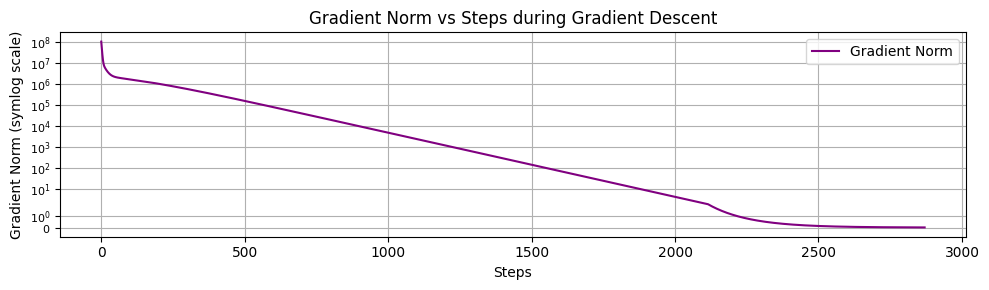


        The plot of gradient norms versus steps shows an initial high magnitude, which gradually decreases as 
        the algorithm progresses. This pattern indicates that the largest adjustments occur in the early stages 
        when the parameters are far from optimal. As gradient descent approaches the minimum, the gradient norms 
        decrease, reflecting smaller adjustments due to lower gradient values. This gradual decrease and final flattening 
        of the gradient norm curve confirm the algorithm’s convergence as it fine-tunes parameters near the optimal point. 
        The symmetric logarithmic scale on the y-axis helps visualize both large and small gradient values, highlighting 
        the diminishing updates as convergence nears.
    


In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

gradient_norms = [np.linalg.norm(g) for g in arr_grad]

ax.plot(gradient_norms, label="Gradient Norm", color="purple")
ax.set_yscale("symlog")
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Norm (symlog scale)")
ax.set_title("Gradient Norm vs Steps during Gradient Descent")
ax.tick_params(axis='y', labelsize=8)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print(
    """
        The plot of gradient norms versus steps shows an initial high magnitude, which gradually decreases as 
        the algorithm progresses. This pattern indicates that the largest adjustments occur in the early stages 
        when the parameters are far from optimal. As gradient descent approaches the minimum, the gradient norms 
        decrease, reflecting smaller adjustments due to lower gradient values. This gradual decrease and final flattening 
        of the gradient norm curve confirm the algorithm’s convergence as it fine-tunes parameters near the optimal point. 
        The symmetric logarithmic scale on the y-axis helps visualize both large and small gradient values, highlighting 
        the diminishing updates as convergence nears.
    """
)


### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

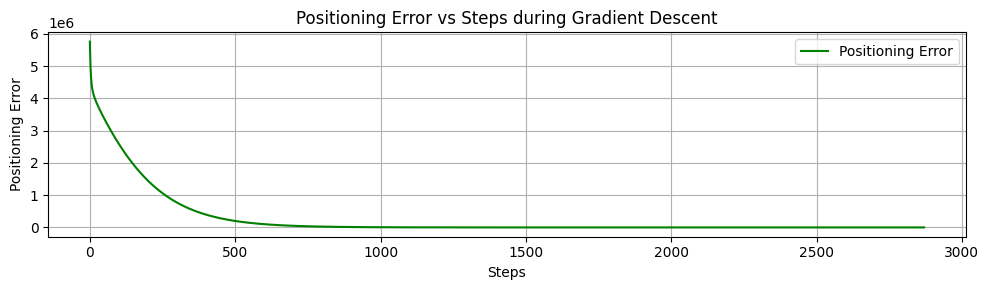


        The plot of positioning errors versus steps shows a steady decrease, indicating that the estimated receiver 
        position converges closer to the true position as the gradient descent progresses. Initially, the positioning 
        error is large, reflecting the inaccuracy of the starting estimates. As steps increase, the error decreases 
        rapidly in the early stages and then more gradually, as gradient descent fine-tunes the position values near 
        the minimum. This pattern confirms the effectiveness of the optimization, with the final stabilization indicating 
        the algorithm’s convergence close to the actual receiver position.

    


In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

positioning_errors = [np.linalg.norm(err) for err in arr_err]

ax.plot(positioning_errors, label="Positioning Error", color="green")
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error")
ax.set_title("Positioning Error vs Steps during Gradient Descent")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
print(
    """
        The plot of positioning errors versus steps shows a steady decrease, indicating that the estimated receiver 
        position converges closer to the true position as the gradient descent progresses. Initially, the positioning 
        error is large, reflecting the inaccuracy of the starting estimates. As steps increase, the error decreases 
        rapidly in the early stages and then more gradually, as gradient descent fine-tunes the position values near 
        the minimum. This pattern confirms the effectiveness of the optimization, with the final stabilization indicating 
        the algorithm’s convergence close to the actual receiver position.

    """
)

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [13]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.01)

# print the metrics
# Extract results
final_position_error = optimized_params_2[:3] - GroundTruth
final_cost_value = arr_cost[-1] if arr_cost else None
final_gradient_values = arr_grad[-1] if arr_grad else None

# Print the required outputs
print("Optimized Parameters:", optimized_params_2)
print("Final Position Error of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_value)
print("Final Gradient Values:", final_gradient_values)

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46523154e+00]
Final Position Error of Receiver: [-3.06414102 -2.35598329  3.80119585]
Number of Steps Taken for Convergence: 2871
Final Cost Value: 6.197094461711757
Final Gradient Values: [ 0.00049101  0.00273591 -0.00840859 -0.00476703]


In [14]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.001)

# print the metrics
# Extract results
final_position_error = optimized_params_3[:3] - GroundTruth
final_cost_value = arr_cost[-1] if arr_cost else None
final_gradient_values = arr_grad[-1] if arr_grad else None

# Print the required outputs
print("Optimized Parameters:", optimized_params_3)
print("Final Position Error of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", final_cost_value)
print("Final Gradient Values:", final_gradient_values)

Converged !
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45048680e+00]
Final Position Error of Receiver: [-3.0626223  -2.34752101  3.77518774]
Number of Steps Taken for Convergence: 27145
Final Cost Value: 6.197742857487326
Final Gradient Values: [ 0.00154868  0.00862914 -0.02652096 -0.01503548]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [49]:
# !pip install ucimlrepo

In [35]:
from ucimlrepo import fetch_ucirepo


# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# # TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features 
y = phishing_websites.data.targets 
         
# # TO DO: display sizes of X and y (1 mark)
print("Size of X (features):", X.shape)
print("Size of y (target):", y.shape)


Size of X (features): (11055, 30)
Size of y (target): (11055, 1)


In [38]:
y.value_counts()

result
 1        6157
-1        4898
Name: count, dtype: int64

### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

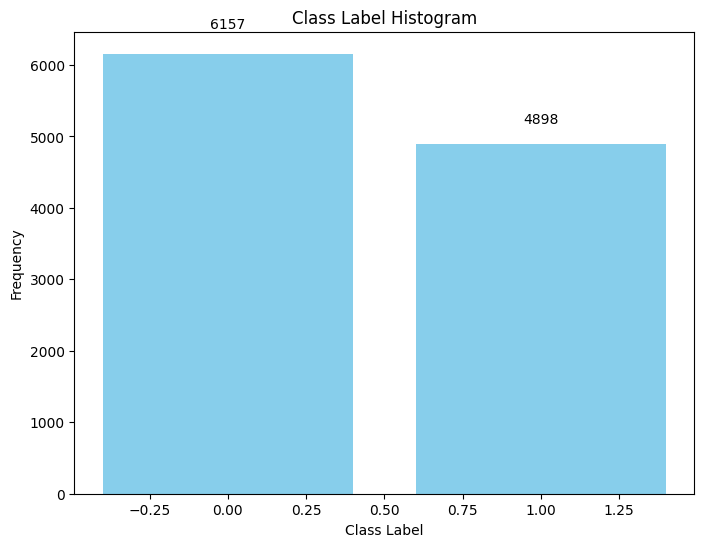

In [ ]:
# TO DO: Check the class distribution of y (2 mark)
# Display exact values for each bin in the histogram
class_counts = y.value_counts()

plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts)), class_counts, color='skyblue')
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class Label Histogram")

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.05 * count, str(count), ha='center', va='bottom')
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [47]:
# !pip install scikit-learn

In [48]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small (features):", X_small.shape)
print("Size of y_small (target):", y_small.shape)


Size of X_small (features): (331, 30)
Size of y_small (target): (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


model = LogisticRegression(max_iter=2000)

# `X` and `y` (1 mark)
model.fit(X, y.values.ravel())
y_pred_full = model.predict(X)
accuracy_full = accuracy_score(y, y_pred_full)
print("Accuracy on full dataset (X, y):", accuracy_full)

# Only first two columns of `X` and `y` (1 mark)
X_two_columns = X.iloc[:, :2]
model.fit(X_two_columns, y.values.ravel())
y_pred_two_columns = model.predict(X_two_columns)
accuracy_two_columns = accuracy_score(y, y_pred_two_columns)
print("Accuracy on first two columns of X and y:", accuracy_two_columns)

# `X_small` and `y_small` (1 mark)
model.fit(X_small, y_small.values.ravel())
y_pred_small = model.predict(X_small)
accuracy_small = accuracy_score(y_small, y_pred_small)
print("Accuracy on smaller dataset (X_small, y_small):", accuracy_small)


Accuracy on full dataset (X, y): 0.9281772953414744
Accuracy on first two columns of X and y: 0.5610131162369968
Accuracy on smaller dataset (X_small, y_small): 0.945619335347432


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [ ]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import pprint


# Function to train and evaluate model on different datasets
def evaluate_model(X_train, X_test, y_train, y_test):

    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train.values.ravel())
    
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    y_test_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_pred_proba)
    
    return {
        "Data Size": X_train.shape[0] + X_test.shape[0],
        "Number of Training Samples": X_train.shape[0],
        "Number of Testing Samples": X_test.shape[0],
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": test_log_loss
    }

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)
results_full = evaluate_model(X_train_full, X_test_full, y_train_full, y_test_full)
print("\nFull Dataset Results:")
pprint.pp(results_full)

X_two_columns = X.iloc[:, :2]
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_two_columns, y, test_size=0.3, random_state=42)
results_two_columns = evaluate_model(X_train_two, X_test_two, y_train_two, y_test_two)
print("\nFirst Two Columns Results:")
pprint.pp(results_two_columns)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)
results_small = evaluate_model(X_train_small, X_test_small, y_train_small, y_test_small)
print("\nSmaller Dataset Results:")
pprint.pp(results_small)



Full Dataset Results:
{'Data Size': 11055,
 'Number of Training Samples': 7738,
 'Number of Testing Samples': 3317,
 'Training Accuracy': 0.9311191522357198,
 'Testing Accuracy': 0.9219173952366596,
 'Log Loss': 0.18794223324119436}

First Two Columns Results:
{'Data Size': 11055,
 'Number of Training Samples': 7738,
 'Number of Testing Samples': 3317,
 'Training Accuracy': 0.5540191263892479,
 'Testing Accuracy': 0.5773289116671692,
 'Log Loss': 0.6773543714260858}

Smaller Dataset Results:
{'Data Size': 331,
 'Number of Training Samples': 231,
 'Number of Testing Samples': 100,
 'Training Accuracy': 0.948051948051948,
 'Testing Accuracy': 0.93,
 'Log Loss': 0.19231080415833277}


### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

# Function to train and evaluate model on different datasets
def evaluate_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train.values.ravel())
    
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    y_test_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_pred_proba)
    
    return {
        "Data Size": X_train.shape[0] + X_test.shape[0],
        "Number of Training Samples": X_train.shape[0],
        "Number of Testing Samples": X_test.shape[0],
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": test_log_loss
    }

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=0)
results_full = evaluate_model(X_train_full, X_test_full, y_train_full, y_test_full)

X_two_columns = X.iloc[:, :2]
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_two_columns, y, test_size=0.3, random_state=0)
results_two_columns = evaluate_model(X_train_two, X_test_two, y_train_two, y_test_two)

X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=0)
results_small = evaluate_model(X_train_small, X_test_small, y_train_small, y_test_small)

results = pd.DataFrame([results_full, results_two_columns, results_small])
results.columns = ["Data size", "Training samples", "Testing samples", "Training accuracy", "Testing accuracy", "Log loss"]

print(results)

   Data size  Training samples  Testing samples  Training accuracy  \
0      11055              7738             3317           0.932282   
1      11055              7738             3317           0.562807   
2        331               231              100           0.943723   

   Testing accuracy  Log loss  
0          0.922822  0.190326  
1          0.556828  0.683573  
2          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [63]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)

print("Dimension of the predicted output:", y_pred.shape)

print("Dimension of the target vector (y_test):", y_test.shape)

Dimension of the predicted output: (3317,)
Dimension of the target vector (y_test): (3317, 1)


In [68]:
# !pip install seaborn

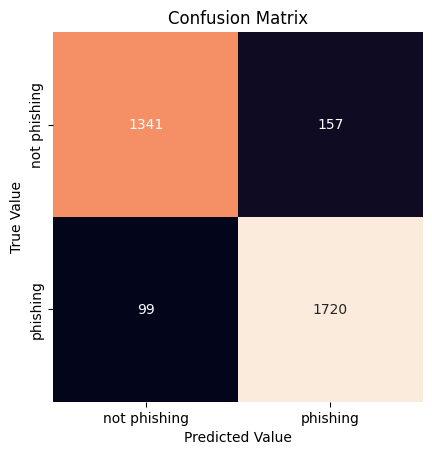

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()

In [67]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred, target_names=['not phishing', 'phishing'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

not phishing       0.93      0.90      0.91      1498
    phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---